In [1]:
# %matplotlib inline 

# %matplotlib ipympl
# %matplotlib widget

In [2]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

## Import data

Ascending order로 되어있어야 작동한다. 

In [16]:
kodex200_ts_d_df = pd.read_pickle('./data_files/kodex200_ts_d_df.pkl') # 
kodex200_ts_d_df = kodex200_ts_d_df.sort_index()
kodex200_ts_d_df.head()

,open,high,low,close,volume
date,,,,,
2015-12-29,22407,22554,22328,22554,4947236
2015-12-30,22609,22665,22430,22439,7619883
2016-01-04,22365,22374,21983,21983,6928106
2016-01-05,21941,22199,21941,22121,12419517
2016-01-06,22121,22144,21849,21960,10875053


In [17]:
kodex200_ts_m_df = pd.read_pickle('./data_files/kodex200_ts_m_df.pkl') # minute
kodex200_ts_m_df = kodex200_ts_m_df.sort_index()
kodex200_ts_m_df.head()

,open,high,low,close,volume
datetime,,,,,
2020-01-28 10:01:00,29749,29774,29739,29769,19646
2020-01-28 10:02:00,29779,29789,29759,29789,25290
2020-01-28 10:03:00,29789,29804,29789,29799,20806
2020-01-28 10:04:00,29794,29804,29794,29804,14493
2020-01-28 10:05:00,29804,29814,29794,29809,11647


In [18]:
class CustomPandasData(bt.feeds.pandafeed.PandasData):
    params = (
        ('datetime', None), 
        
        ('open', -1), # -1은 auto. Manually 1, 2, 3, 4, 5 로도 가능. 
        ('high', -1), 
        ('low', -1),
        ('close', -1), 
        ('volume', -1),
    )
    
    datafields = [
        'datetime', 
        'open', 
        'high', 
        'low', 
        'close', 
        'volume',
    ]

위의 CustomPandasData class 없이도 잘 된다. 

## Adding an indicator

Having heard of indicators, the next thing anyone would add to the strategy is one of them. For sure they must be much better than a simple “3 lower closes” strategy.

Inspired in one of the examples from PyAlgoTrade a strategy using a Simple Moving Average.

- Buy “AtMarket” if the close is greater than the Average

- If in the market, sell if the close is smaller than the Average

- Only 1 active operation is allowed in the market

Most of the existing code can be kept in place. Let’s add the average during init and keep a reference to it:


`self.sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.maperiod)`

And of course the logic to enter and exit the market will rely on the Average values. Look in the code for the logic.

* The starting cash will be 1000 monetary units to be in line with the PyAlgoTrade example and no commission will be applied

In [19]:
# Create a Stratey
class GoldenCrossStrategy(bt.Strategy):
    params = (
        ('ma5period', 5),
        ('ma10period', 10)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma5 = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.ma5period)
        
        self.sma10 = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.ma10period)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.sma5[0] > self.sma10[0]:
                
                print("Buy timing!")

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.sma5[0] < self.sma10[0]:
                
                print("Sell timing!")
                
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 1000000000.00
2016-01-13, Close, 21900.00
2016-01-14, Close, 21692.00
2016-01-15, Close, 21466.00
2016-01-18, Close, 21448.00
2016-01-19, Close, 21563.00
2016-01-20, Close, 21070.00
2016-01-21, Close, 21019.00
2016-01-22, Close, 21476.00
2016-01-25, Close, 21591.00
2016-01-26, Close, 21319.00
2016-01-27, Close, 21619.00
2016-01-28, Close, 21651.00
Buy timing!
2016-01-28, BUY CREATE, 21651.00
2016-01-29, BUY EXECUTED, Price: 21582.00, Cost: 215820.00, Comm 647.46
2016-01-29, Close, 21683.00
2016-02-01, Close, 21840.00
2016-02-02, Close, 21688.00
2016-02-03, Close, 21439.00
2016-02-04, Close, 21835.00
2016-02-05, Close, 21890.00
2016-02-11, Close, 21301.00
2016-02-12, Close, 21144.00
Sell timing!
2016-02-12, SELL CREATE, 21144.00
2016-02-15, SELL EXECUTED, Price: 21365.00, Cost: 215820.00, Comm 640.95
2016-02-15, OPERATION PROFIT, GROSS -2170.00, NET -3458.41
2016-02-15, Close, 21420.00
2016-02-16, Close, 21734.00
2016-02-17, Close, 21761.00
2016-02-18, Close, 2

2018-03-23, SELL CREATE, 30291.00
2018-03-26, SELL EXECUTED, Price: 30215.00, Cost: 311110.00, Comm 906.45
2018-03-26, OPERATION PROFIT, GROSS -8960.00, NET -10799.78
2018-03-26, Close, 30555.00
2018-03-27, Close, 30684.00
2018-03-28, Close, 30306.00
2018-03-29, Close, 30555.00
2018-03-30, Close, 30632.00
2018-04-02, Close, 30560.00
2018-04-03, Close, 30497.00
2018-04-04, Close, 30028.00
2018-04-05, Close, 30445.00
2018-04-06, Close, 30296.00
2018-04-09, Close, 30507.00
2018-04-10, Close, 30536.00
2018-04-11, Close, 30440.00
2018-04-12, Close, 30435.00
Buy timing!
2018-04-12, BUY CREATE, 30435.00
2018-04-13, BUY EXECUTED, Price: 30545.00, Cost: 305450.00, Comm 916.35
2018-04-13, Close, 30636.00
2018-04-16, Close, 30660.00
2018-04-17, Close, 30617.00
2018-04-18, Close, 30958.00
2018-04-19, Close, 31130.00
2018-04-20, Close, 30924.00
2018-04-23, Close, 30905.00
2018-04-24, Close, 30732.00
2018-04-25, Close, 30536.00
2018-04-26, Close, 30919.00
2018-04-27, Close, 31201.00
2018-04-30, Clos

2019-07-29, SELL CREATE, 26757.00
2019-07-30, SELL EXECUTED, Price: 26842.00, Cost: 271340.00, Comm 805.26
2019-07-30, OPERATION PROFIT, GROSS -2920.00, NET -4539.28
2019-07-30, Close, 26827.00
2019-07-31, Close, 26558.00
2019-08-01, Close, 26528.00
2019-08-02, Close, 26229.00
2019-08-05, Close, 25662.00
2019-08-06, Close, 25303.00
2019-08-07, Close, 25149.00
2019-08-08, Close, 25258.00
2019-08-09, Close, 25433.00
2019-08-12, Close, 25472.00
2019-08-13, Close, 25213.00
2019-08-14, Close, 25393.00
2019-08-16, Close, 25308.00
2019-08-19, Close, 25467.00
Buy timing!
2019-08-19, BUY CREATE, 25467.00
2019-08-20, BUY EXECUTED, Price: 25452.00, Cost: 254520.00, Comm 763.56
2019-08-20, Close, 25716.00
2019-08-21, Close, 25766.00
2019-08-22, Close, 25562.00
2019-08-23, Close, 25537.00
2019-08-26, Close, 25164.00
2019-08-27, Close, 25243.00
2019-08-28, Close, 25487.00
Sell timing!
2019-08-28, SELL CREATE, 25487.00
2019-08-29, SELL EXECUTED, Price: 25497.00, Cost: 254520.00, Comm 764.91
2019-08-2

<IPython.core.display.Javascript object>


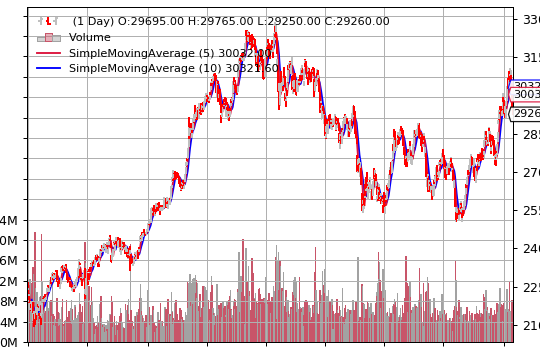

In [20]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro(stdstats=False)

    # Add a strategy
    cerebro.addstrategy(GoldenCrossStrategy)

    # Create a Data Feed
    dataframe = kodex200_ts_d_df
    data = CustomPandasData(dataname=dataframe)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000000000.0) # 10억으로 시작. 

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.003) # 증권거래세 0.3%

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    # Plot the result
    cerebro.plot(style='bar')